In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import jax
import jax.numpy as jnp
from src.spectral_xpci.xscatter import get_delta_beta_mix
from src.spectral_xpci.simulate import get_wavelen, apply_psf, simulate_projection
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

from multislice import Material, make_fiber_phantom, simulate_multislice  # new!

In [2]:

pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)
glass = Material('glass', 'O(53.9559)Na(2.8191)Al(1.1644)Si(37.7220)K(0.3321)', 2.230)
breast = Material('breast tissue', 'C(33.2)N(3.0)O(52.7)Na(0.1)P(0.1)S(0.2)Cl(0.1)', 1.02)

plt.rcParams.update({
    'figure.dpi': 150,
    'font.size':10,
    'axes.titlesize':10,
    'axes.labelsize':8,
    'axes.linewidth': .5,
    'xtick.top': True, 
    'ytick.right': True, 
    'xtick.direction': 'in', 
    'ytick.direction': 'in',
    'xtick.labelsize':8,
    'ytick.labelsize':8,
    'legend.fontsize': 8,
    'lines.linewidth':1,
    'image.cmap':'gray'
    })

def add_scalebar(ax, sz, Nx, real_dx, real_units, color='k'):
    width_px = sz * Nx 
    label = f'{real_dx * width_px:.0f} {real_units}'
    scalebar = AnchoredSizeBar(ax.transData, width_px, label, 'lower left', size_vertical=1, frameon=False, color=color)
    ax.add_artist(scalebar)

def im_min(im1, im2):
    return min(np.min(im1), np.min(im2))

def im_max(im1, im2):
    return max(np.max(im1), np.max(im2))

def NF(a, E, z):  
    """Fresnel number"""
    return a**2 / (get_wavelen(E)*z)

In [3]:

def make_fiber_phantom_vacuum(N, Nz, dx, fiber_width, energy, fiber_material, background_material, height_fraction=0.8):
## vacuum background for testing
    fov = N*dx
    fiber_height = height_fraction*fov
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        mask = np.where((X <= fiber_width/2) & (Y <= fiber_height/2))  
        obj[z][mask] = 1

    # matdict = {0: background_material, 1: fiber_material}
    matdict = {1: fiber_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta


# Experiments

Reasoning behind parameter choices:

- energy = 20 keV ~ rough average for a mammography energy spectrum.
- thickness = 5 cm ~ reasonable compressed breast thickness.
- detector pixels = 5 um ~ very high res but still shows fringe effects.
- phantom pixels = approx 0.5 um ~ much higher resolution than the detector for accurate simulation.
- detector psf = None ~ ignoring this effect for now, need to check implementation.

detector px = 5.0 um, E = 20 keV, thickness = 50.0 mm ==> NF = 8.07
fiber width = 20 micron, Nz = 1
proj approx done - 1.98 s
multislice done - 0.11 s


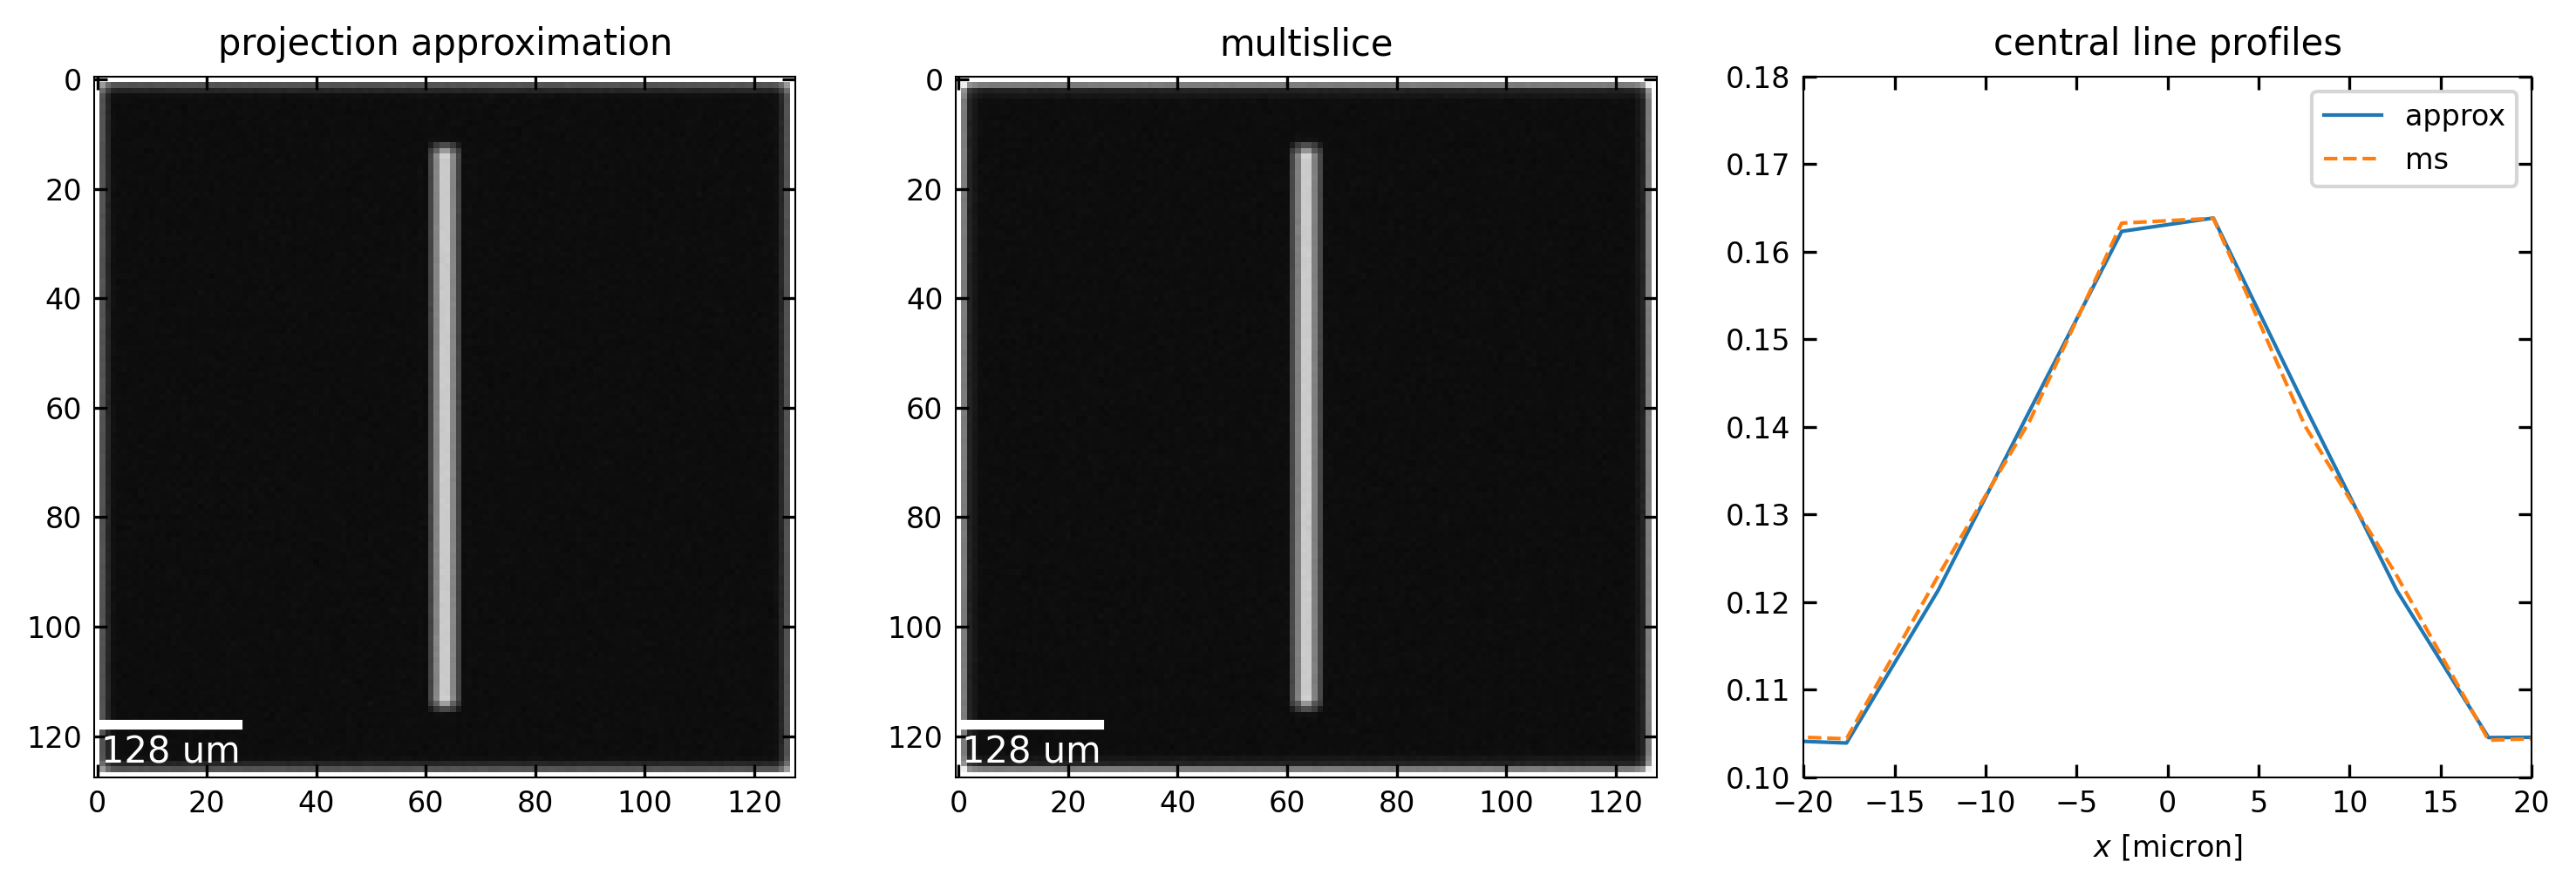

fiber width = 20 micron, Nz = 5
proj approx done - 0.05 s
multislice done - 0.17 s


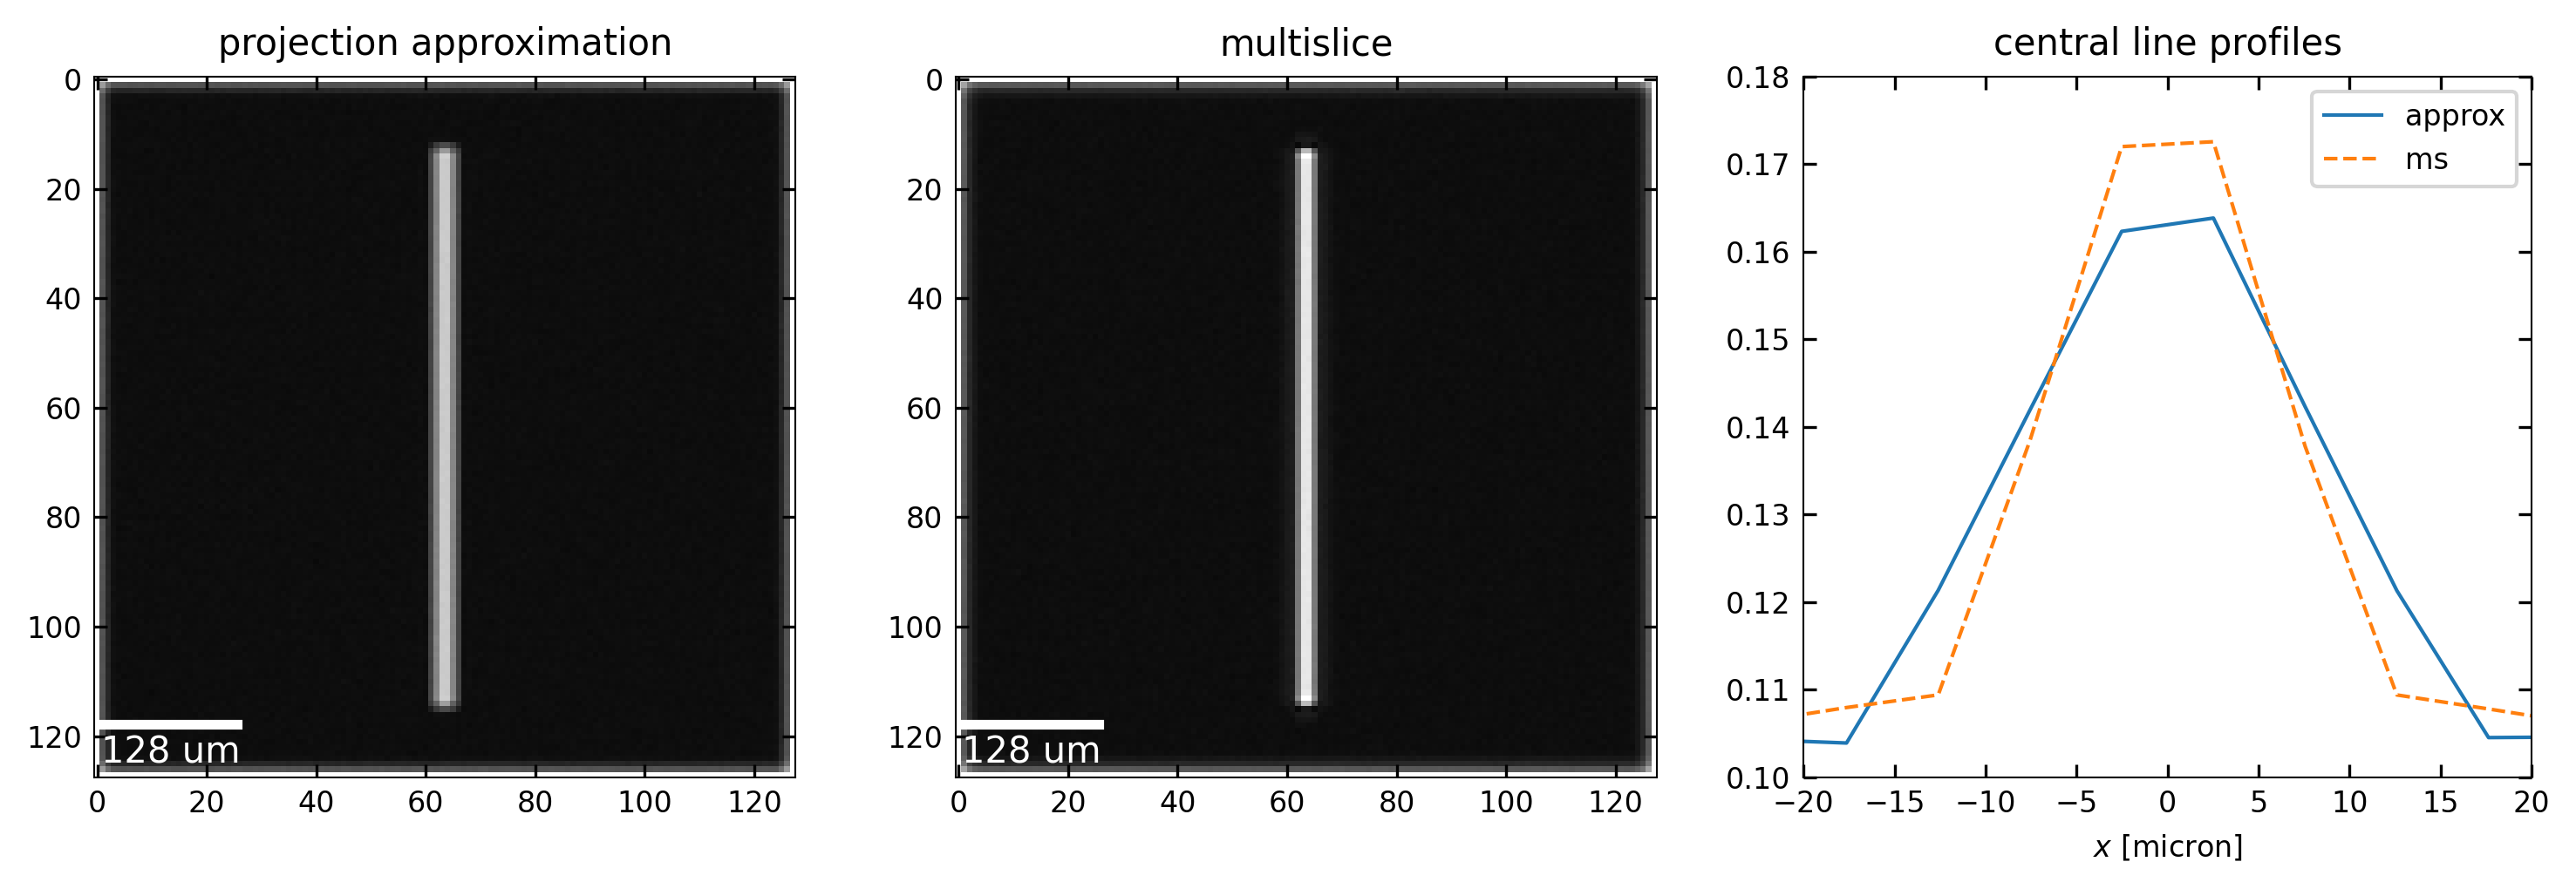

fiber width = 20 micron, Nz = 10
proj approx done - 0.06 s
multislice done - 0.29 s


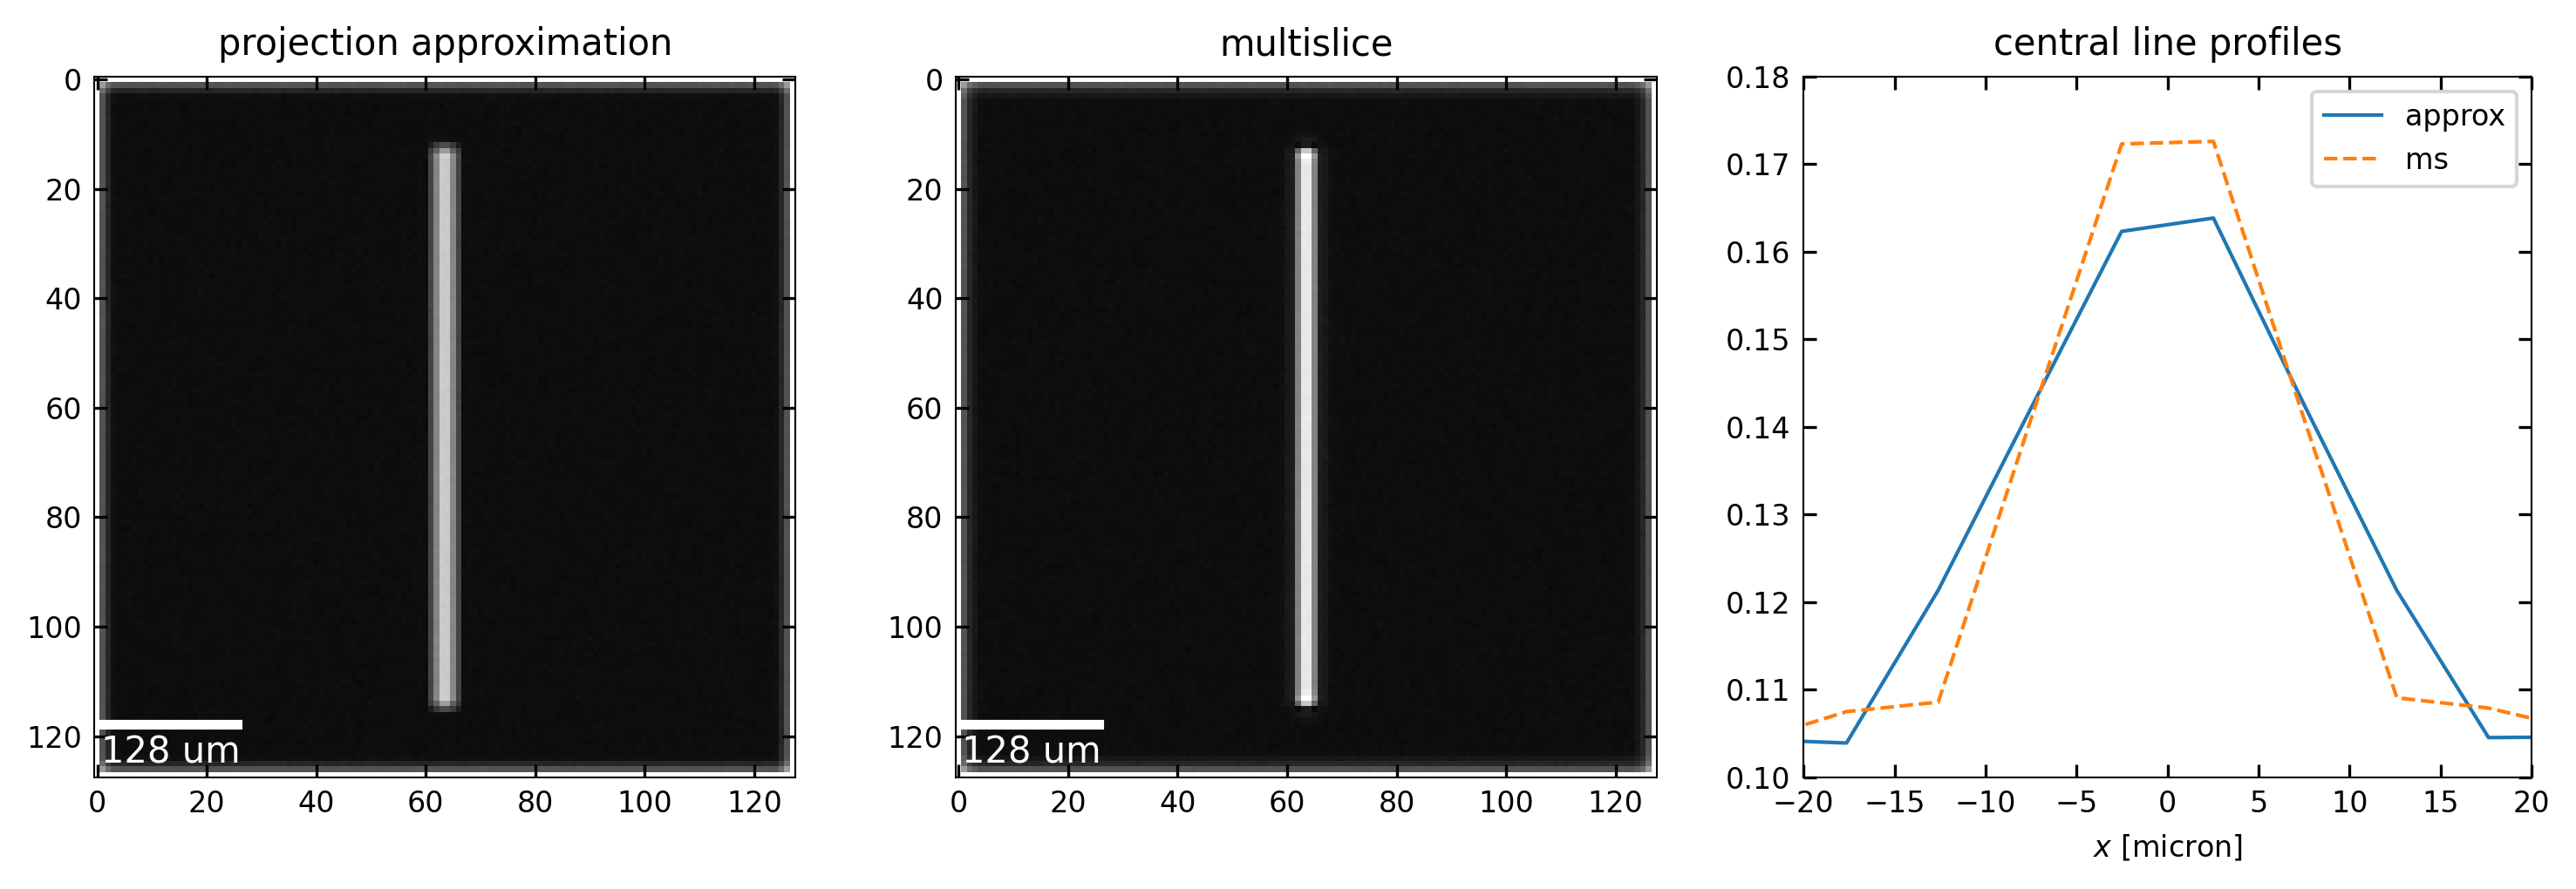

fiber width = 50 micron, Nz = 1
proj approx done - 0.03 s
multislice done - 0.06 s


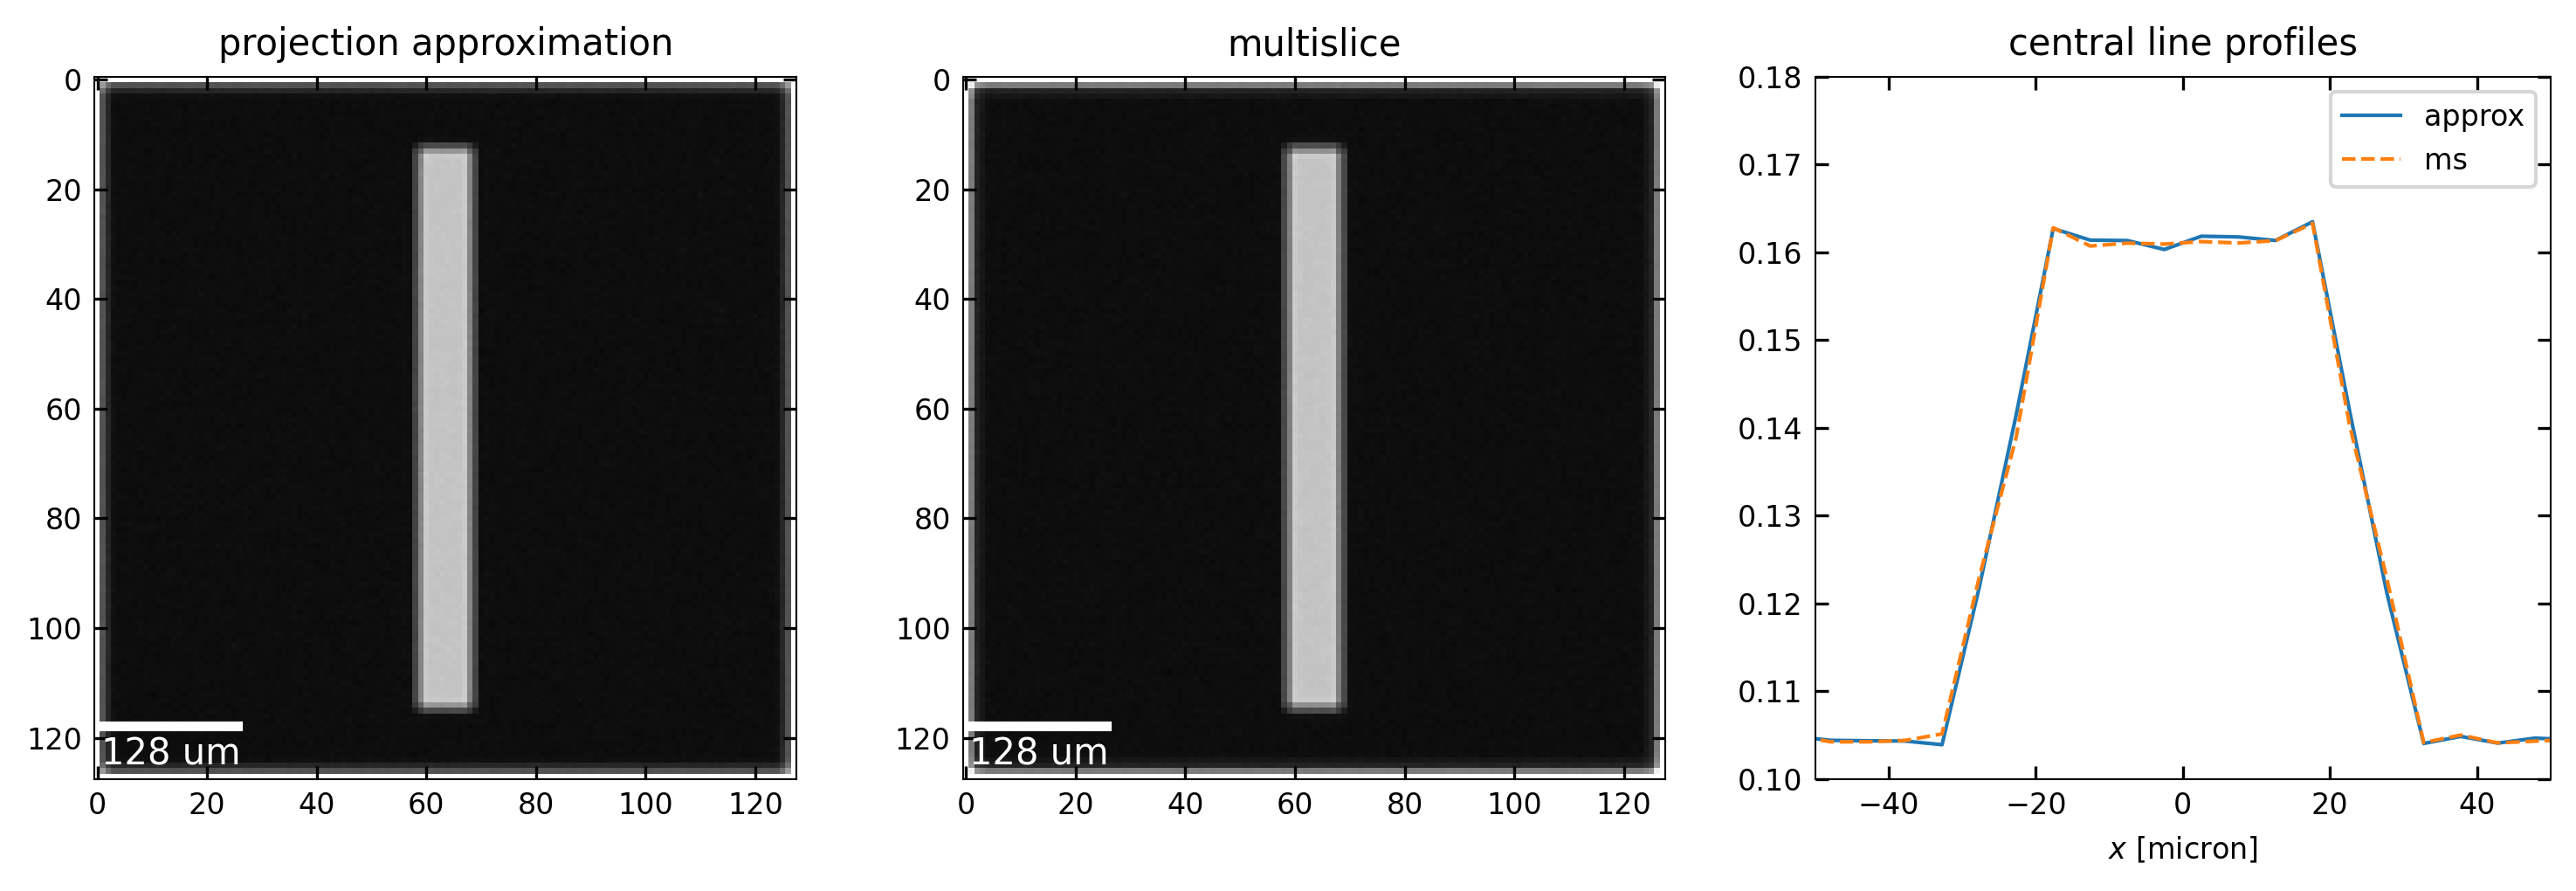

fiber width = 50 micron, Nz = 5
proj approx done - 0.06 s
multislice done - 0.16 s


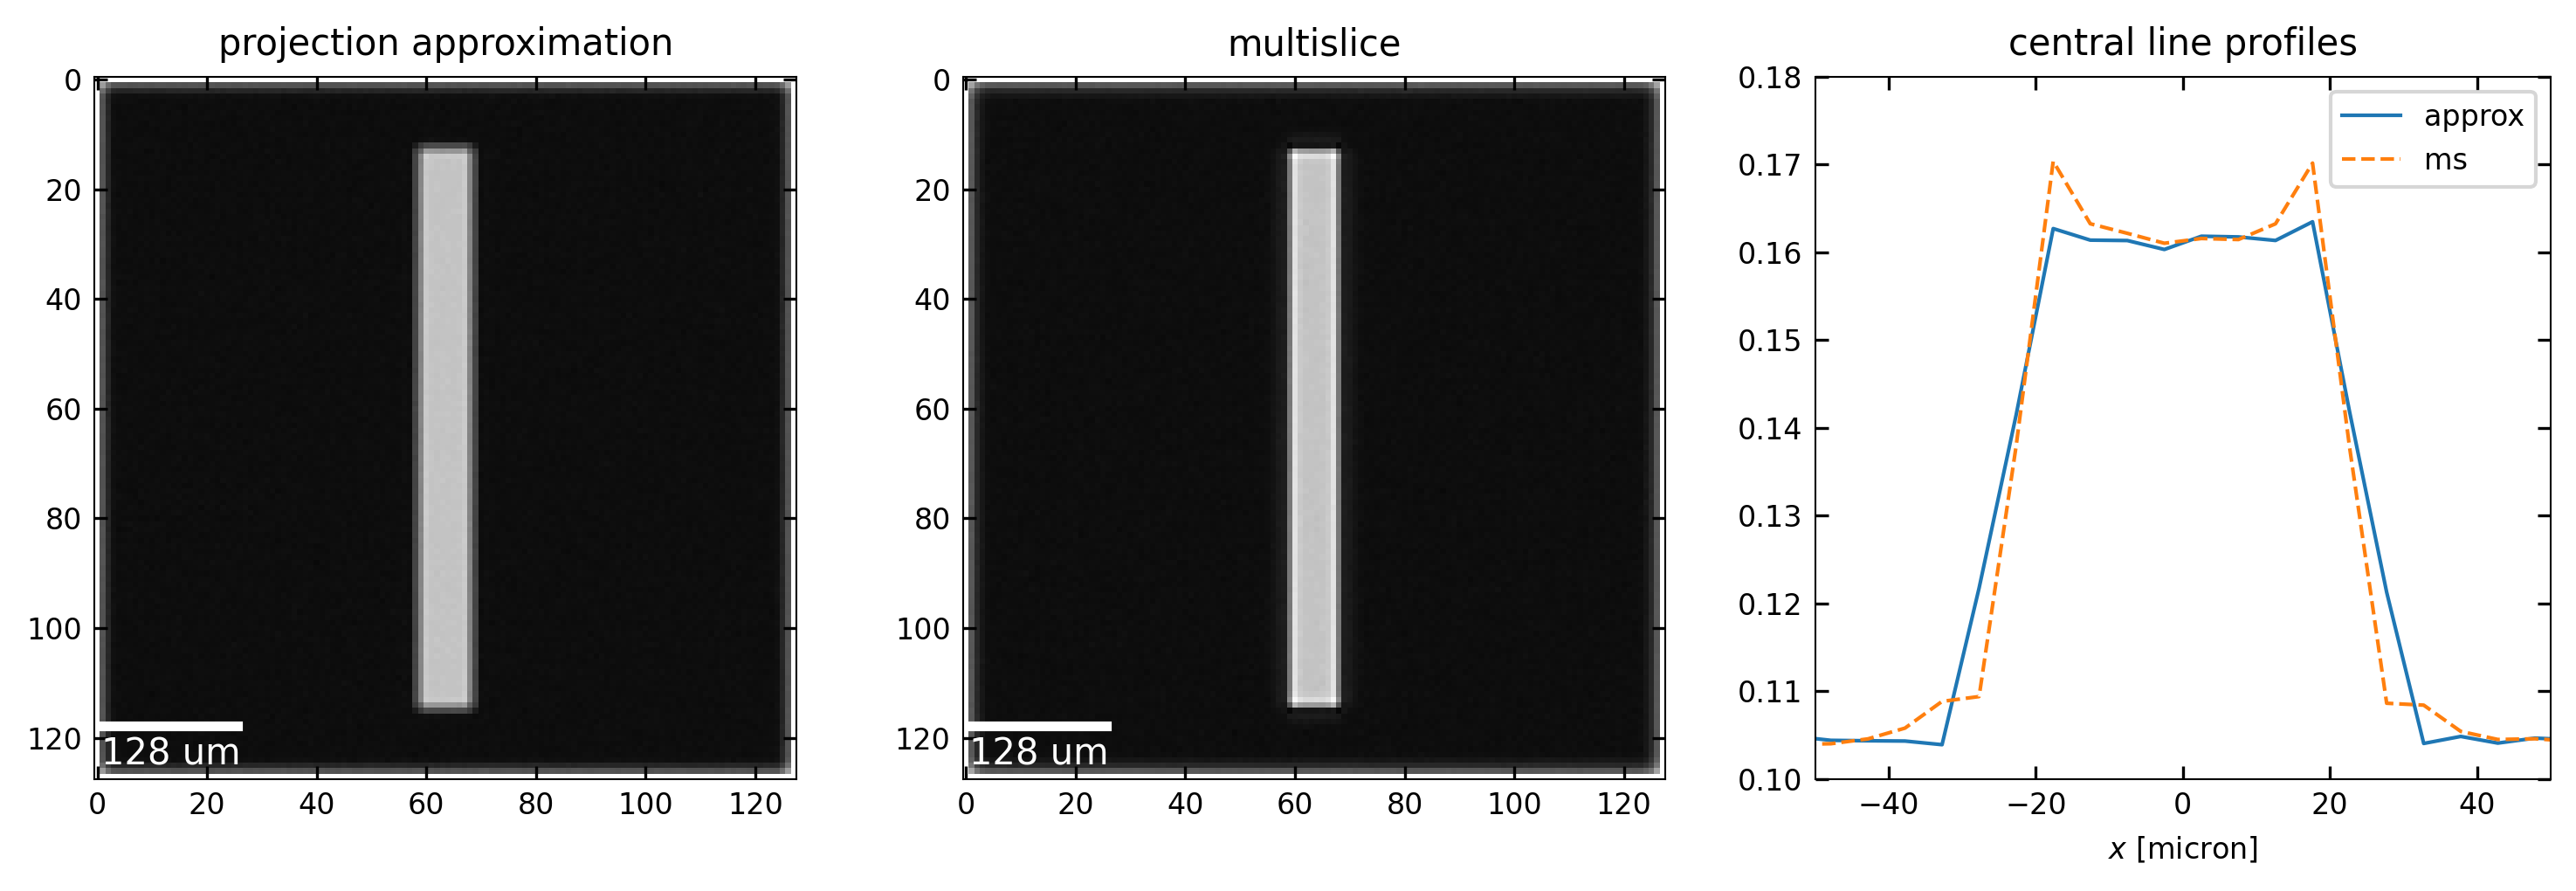

fiber width = 50 micron, Nz = 10
proj approx done - 0.09 s
multislice done - 0.29 s


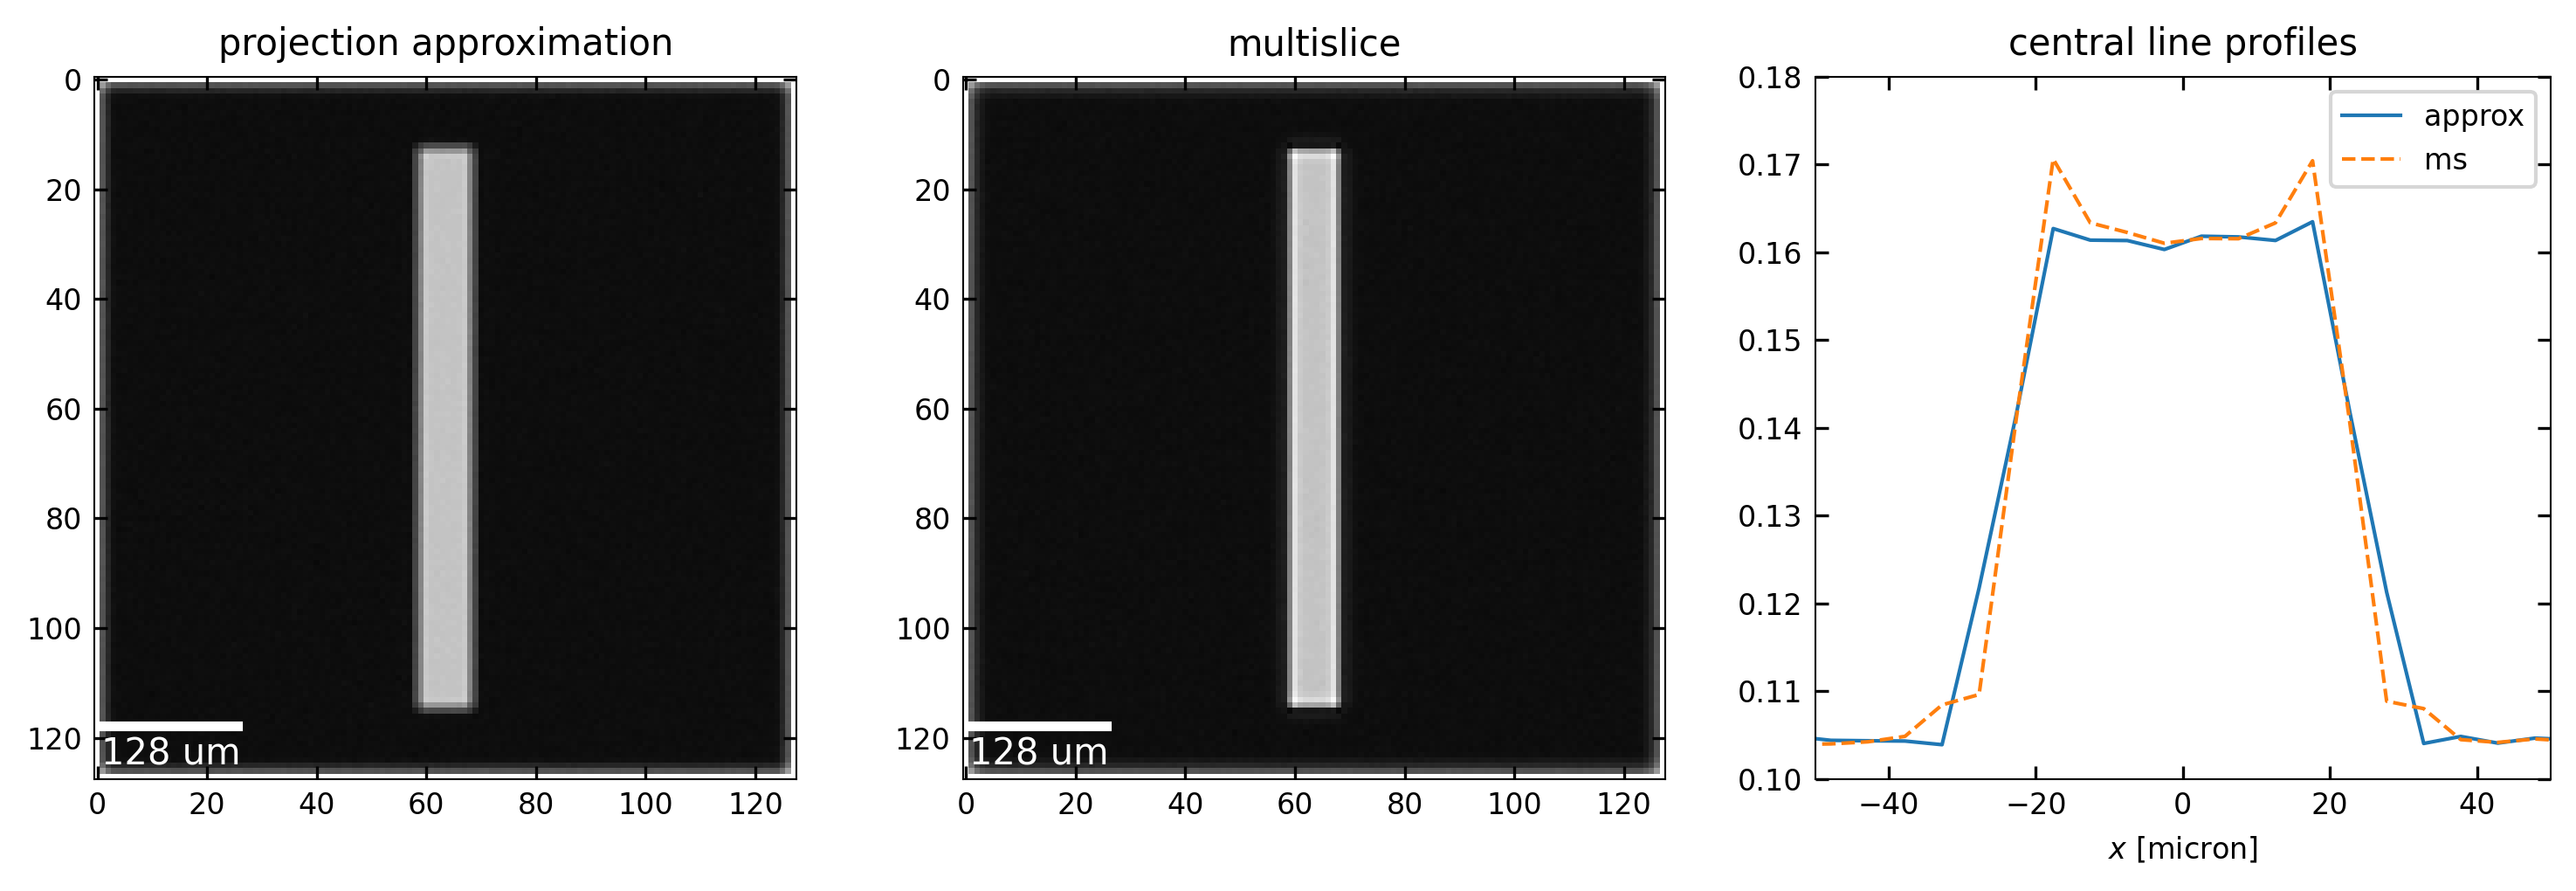

fiber width = 100 micron, Nz = 1
proj approx done - 0.04 s
multislice done - 0.06 s


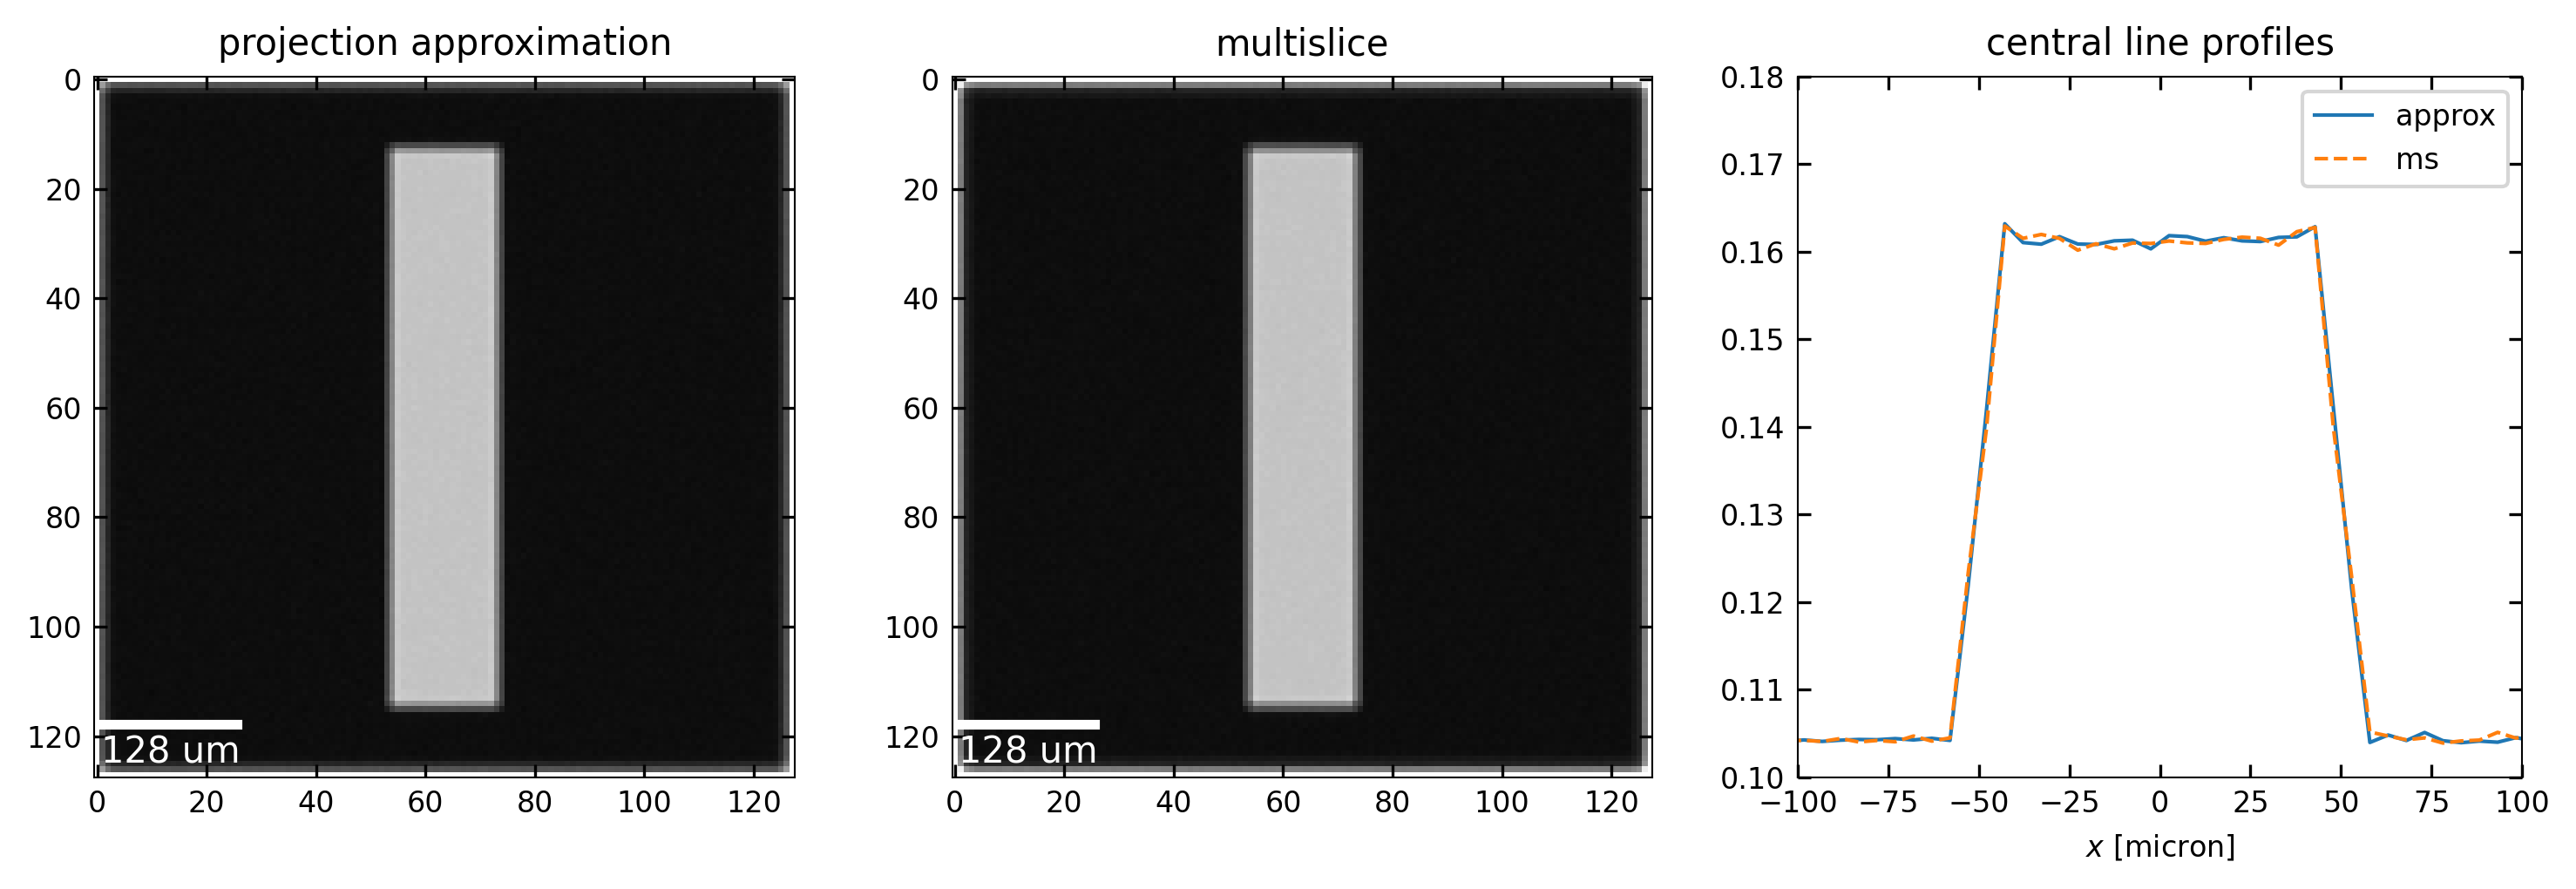

fiber width = 100 micron, Nz = 5
proj approx done - 0.08 s
multislice done - 0.17 s


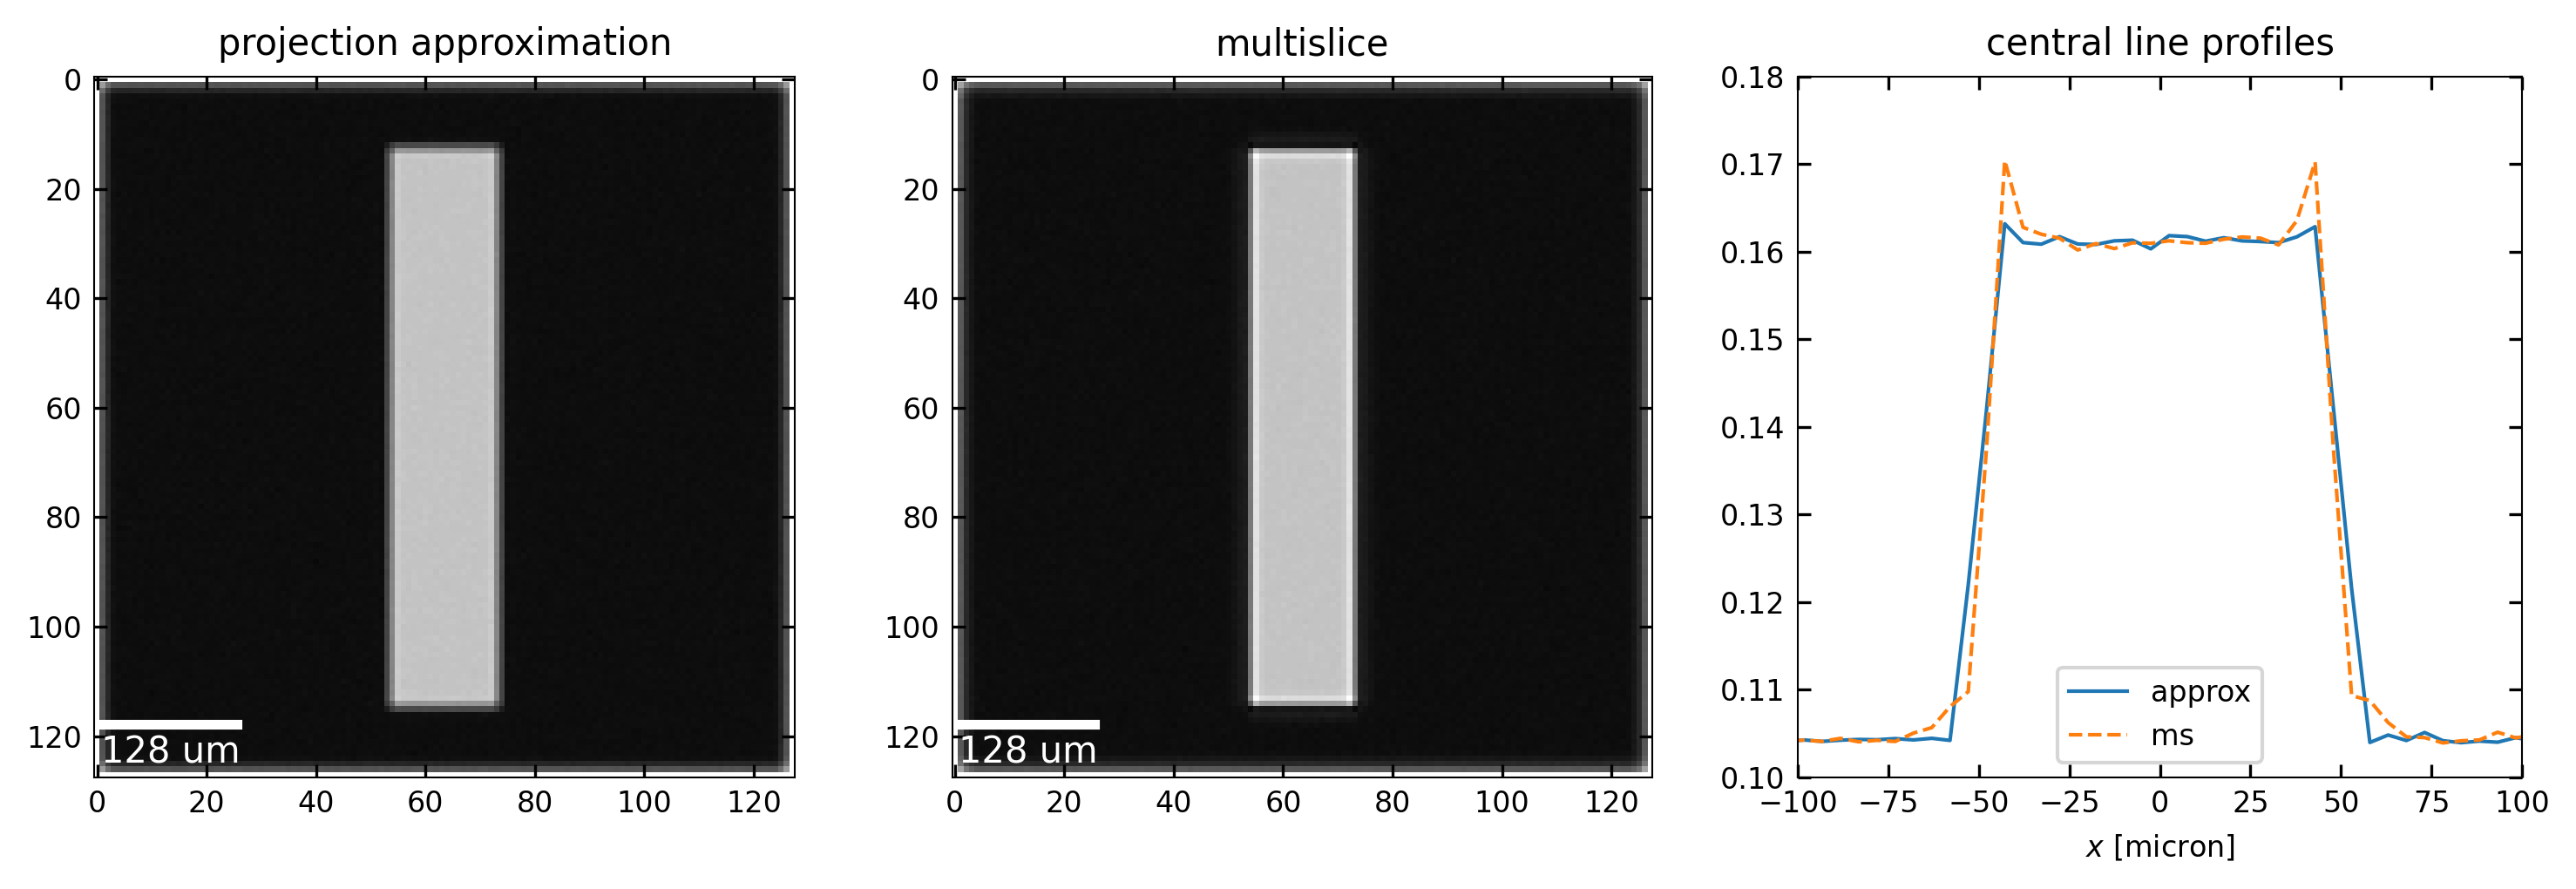

fiber width = 100 micron, Nz = 10
proj approx done - 0.14 s
multislice done - 0.28 s


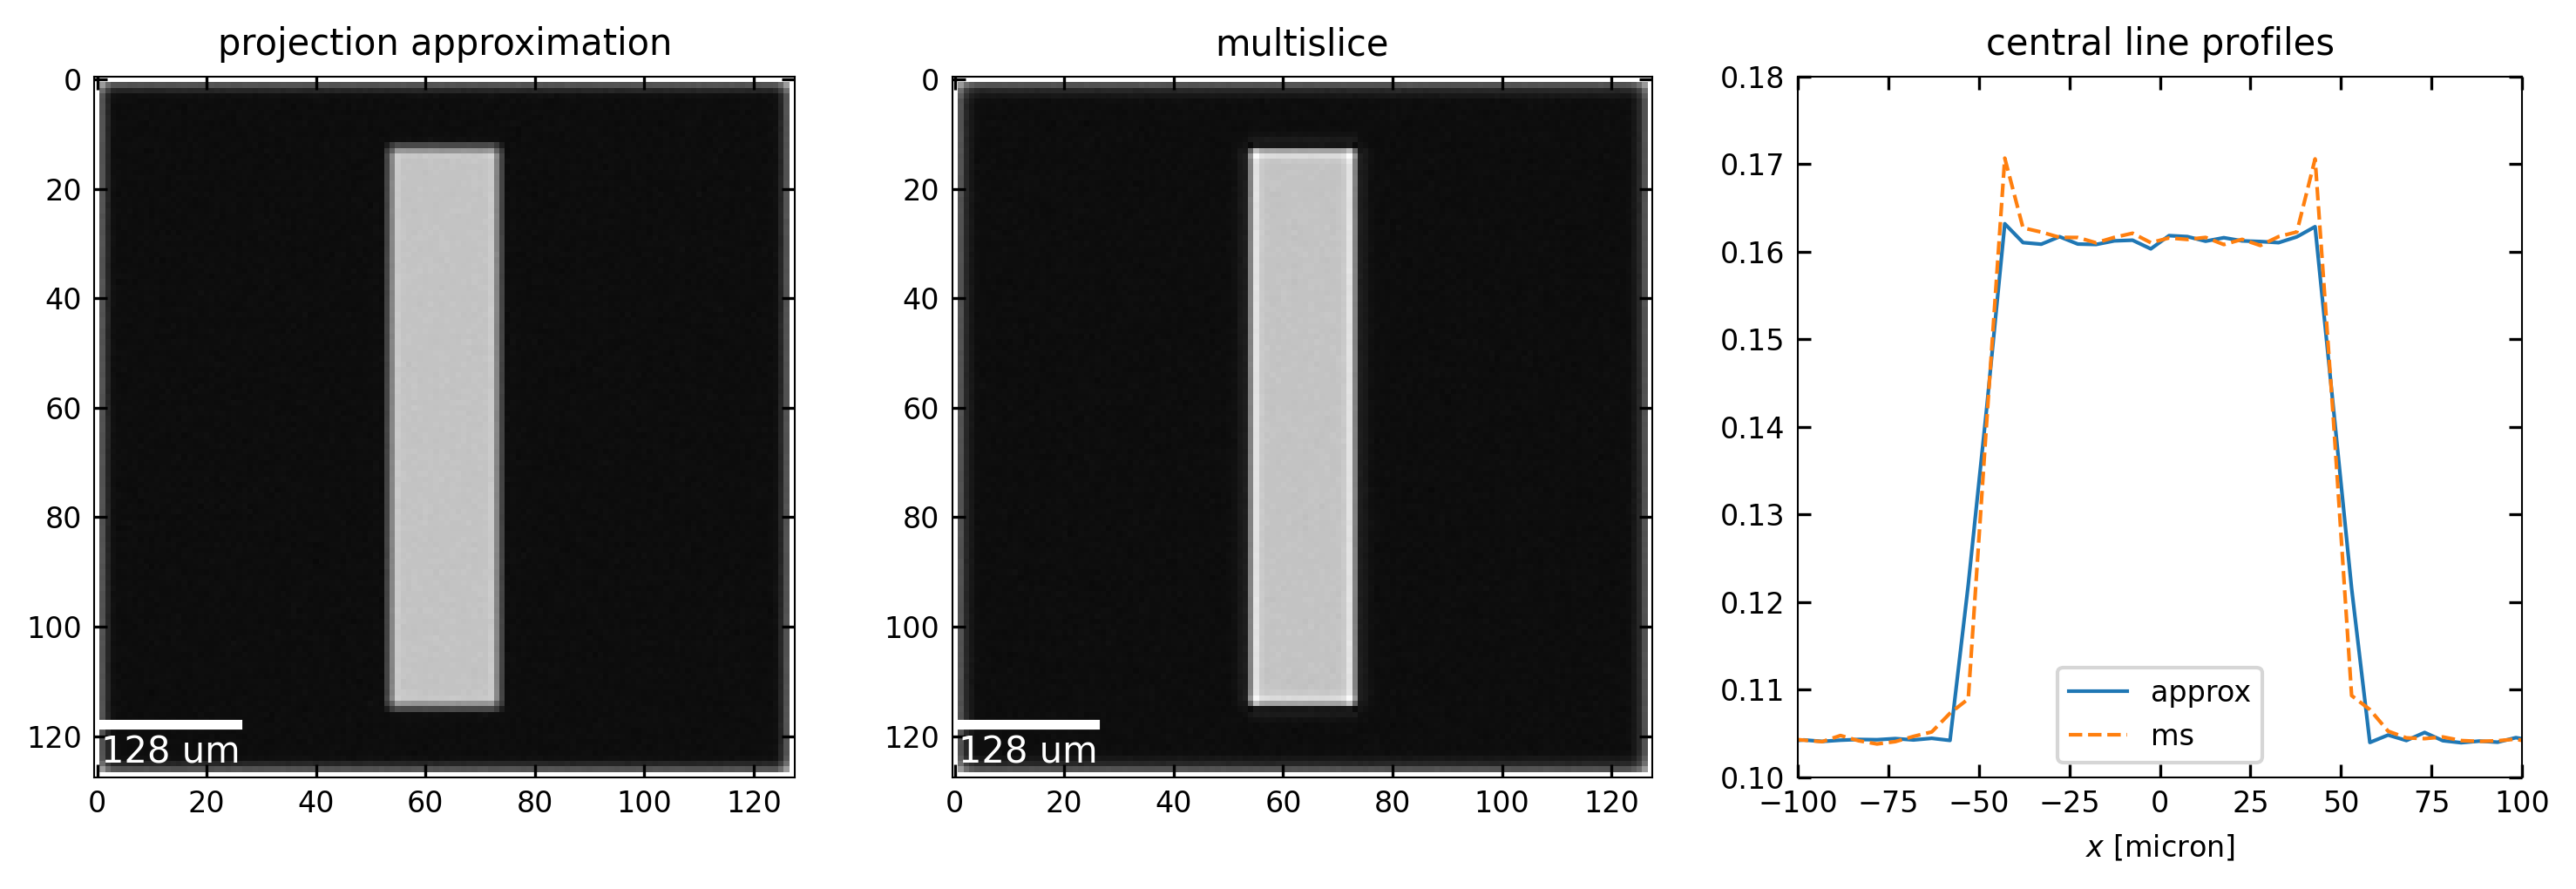

CPU times: user 15.8 s, sys: 2.83 s, total: 18.6 s
Wall time: 12.5 s


In [4]:
%%time

##########################################
### Parameters 

energy = 20
propdist = 30e-2 
I0 = 1e6   # number of incident photons per detector pixel (or `None` for no noise)

# Phantom:
N = 1024
dx = 1.25e-6 / 2     # ~roughly half micron pixels
fov = N*dx           # thickness in the transverse plane (x-y)
thickness = 5e-2     # thickness along propagation axis (z)

# Detector:
det_shape = (128, 128)   # Note -- detector is smaller than phantom! Only 128x128 vs 1024x1024.
det_fov = fov                
det_dx = det_fov / det_shape[0]  
det_psf = None #'lorentzian'
det_fwhm = 1e-6

# Variables:
fiber_width_list = [20e-6, 50e-6, 100e-6]  
Nz_list = [1, 5, 10]  

print(f'detector px = {det_dx*1e6:.1f} um, E = {energy:.0f} keV, thickness = {thickness*1e3:.1f} mm ==> NF = {NF(det_dx, energy, thickness):.2f}')

##########################################
### loop over widths & Nz

for fiber_width in fiber_width_list:
    for Nz in Nz_list:
        print(f'fiber width = {fiber_width*1e6:.0f} micron, Nz = {Nz}')
        
        # Compute dependent parameters & make the phantom.
        dz = thickness/Nz
        phantom_shape = jnp.array([Nz, N, N])
        obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma)
        # obj_delta, obj_beta = make_fiber_phantom_vacuum(N, Nz, dx, fiber_width, energy, fiber_material=nylon, background_material=pmma)

        
        # Simulate with the two methods.
        t0 = time()
        beta_proj = dz * jnp.sum(obj_beta, axis=0)
        delta_proj = dz * jnp.sum(obj_delta, axis=0)
        img_approx = simulate_projection(beta_proj, delta_proj, dx, N, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf) 
        print(f'proj approx done - {time() - t0:.2f} s')

        t0 = time()
        img_ms = simulate_multislice(obj_beta, obj_delta, dx, dz, N, Nz, det_shape, det_dx, det_fwhm, energy, propdist, I0, det_psf=det_psf)
        print(f'multislice done - {time() - t0:.2f} s')

        
        # View the images.
        # Note - the images have some bright fringes at the edges (artifacts of the simulation). Should we crop these out?
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[10,3.5], dpi=300)
        # kw = {'cmap':'gray', 'vmin':im_min(img_approx, img_ms), 'vmax':im_max(img_approx, img_ms)}  # so that the images have the same colorscale
        kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}  # so that the images have the same colorscale

        ax[0].set_title('projection approximation')
        m = ax[0].imshow(img_approx, **kw)
        # fig.colorbar(m, ax=ax[0])

        ax[1].set_title('multislice')
        m = ax[1].imshow(img_ms, **kw)
        # fig.colorbar(m, ax=ax[1])

        for i in range(2):  # for the first two axes...
            add_scalebar(ax[i], 0.2, det_shape[0], det_dx*1e6, 'um', color='w')
            # ax[i].axis('off')  # get rid of the x and y ticks

        ax[2].set_title('central line profiles')
        i_row = int((det_shape[0])/2)  
        x = 1e6 * np.linspace(-det_fov/2, det_fov/2, det_shape[0])
        ax[2].set_xlabel('$x$ [micron]')
        ax[2].set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
        ax[2].set_ylim(kw['vmin'], kw['vmax'])
        ax[2].plot(x, img_approx[i_row], linestyle='-', label='approx')  
        ax[2].plot(x, img_ms[i_row], linestyle='--', label='ms')
        ax[2].legend()

        fig.tight_layout()
        plt.show()

        